# Step 1-3: Feature Selection 

### Correlations of percentage change

## Summary

summary 

In [2]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import warnings

warnings.filterwarnings("ignore")

In [3]:
# Config
TARGET_VARIABLES = 'co2'
CANDIDATE_FEATURES = ['gdp', 'primary_energy_consumption']
G20_COUNTRIES = [
    'United States', 'China', 'Japan', 'Germany', 
    'United Kingdom', 'France', 'Italy', 'Canada',
    'Brazil', 'Russia', 'India', 'Australia', 
    'Mexico', 'Indonesia', 'Turkey', 'Saudi Arabia',
    'South Africa', 'Argentina', 'South Korea'
]
SELECTED_COUNTRIES = ['United States', 'China', 'India']
MAX_LAGS = 4
TEST_SIZE = 9

PRODUCTION_FEATURES = [
    'coal_production',
    'oil_production',
    'gas_production'
]

CONSUMPTION_FEATURES = [
    'coal_consumption',
    'oil_consumption',
    'gas_consumption',
    'nuclear_consumption',
    'biofuel_consumption',
    'solar_consumption',
    'wind_consumption',
    'hydro_consumption',
    'other_renewables_consumption'
]

SHARE_FEATURES = [
    'coal_share_energy',
    'oil_share_energy',
    'gas_share_energy',
    'nuclear_share_energy',
    'biofuel_share_energy',
    'solar_share_energy',
    'wind_share_energy',
    'hydro_share_energy',
    'other_renewables_share_energy'
]

In [4]:
def load_data(save_dir='data'):
    data_files = {
        'all_data_df': os.path.join(save_dir, 'all_data_df.csv'),
        'g20_lag_df': os.path.join(save_dir, 'g20_lag_df.csv'),
        'lag_three_sel_1969_df': os.path.join(save_dir, 'lag_three_sel_1969_df.csv')
    }

    dfs = {}
    for name, filepath in data_files.items():
        if os.path.exists(filepath):
            dfs[name] = pd.read_csv(filepath)
            print(f"Loaded {name}: {dfs[name].shape}")
        else:
            print(f"{filepath} not found")
    
    return dfs

In [5]:
data = load_data()
all_data_df = data['all_data_df']
g20_lag_df = data['g20_lag_df']
g20_lag_1969_df = g20_lag_df[g20_lag_df['year'] >= 1969].copy()
g20_lag_1969_df = g20_lag_1969_df[g20_lag_1969_df['year'] < 2023]
lag_three_sel_1969_df = data['lag_three_sel_1969_df']

Loaded all_data_df: (55529, 200)
Loaded g20_lag_df: (3744, 992)
Loaded lag_three_sel_1969_df: (162, 992)


In [6]:
# train_test_split
def tts_by_year(df, test_size=9):
    train_data = {}
    test_data = {}

    for country in df['country'].unique():
        country_data = df[df['country'] == country].sort_values('year')

        split_idx = len(country_data) - test_size
        train_data[country] = country_data.iloc[:split_idx]
        test_data[country] = country_data.iloc[split_idx:]

    train_df = pd.concat(train_data.values(), ignore_index=True)
    test_df = pd.concat(test_data.values(), ignore_index=True)

    return train_df, test_df

In [7]:
train_3_df, test_3_df = tts_by_year(lag_three_sel_1969_df, TEST_SIZE)
train_g20_df, test_g20_df = tts_by_year(g20_lag_1969_df, TEST_SIZE)

print(f"3 countries train shape: {train_3_df.shape}")
print(f"3 countries train years: {train_3_df['year'].min()} - {train_3_df['year'].max()}")
print(f"3 countriees test years: {test_3_df['year'].min()} - {test_3_df['year'].max()}")

3 countries train shape: (135, 992)
3 countries train years: 1969 - 2013
3 countriees test years: 2014 - 2022


In [14]:
def calculate_pct_change(df, feature_cat, max_lags=MAX_LAGS):
    df_copy = df.copy()
    df_copy = df_copy.sort_values(['country', 'year']).reset_index(drop=True)
    pct_change_cols = []

    for feature in feature_cat:
        if feature not in df_copy.columns:
            continue

        # Pct change on current values
        lag1_col = f"{feature}_lag1"
        if lag1_col in df_copy.columns:
            df_copy[f"{feature}_pct_change"] = ((df_copy[feature] - df_copy[lag1_col]) / df_copy[lag1_col] * 100)
            pct_change_cols.append(f"{feature}_pct_change")

        # Pct change on lagged values
        for lag in range(1, max_lags):
            lag_col = f"{feature}_lag{lag}"
            prev_lag_col = f"{feature}_lag{lag+1}"
            
            if lag_col in df_copy.columns and prev_lag_col in df_copy.columns:
                df_copy[f"{lag_col}_pct_change"] = ((df_copy[lag_col] - df_copy[prev_lag_col]) / df_copy[prev_lag_col] * 100)
                pct_change_cols.append(f"{lag_col}_pct_change")

        # Lag4 for the first row = 0, then shift lag3_pct by country
        last_lag_col = f"{feature}_lag{max_lags}"
        lag3_pct_col = f"{feature}_lag{max_lags-1}_pct_change"

        if last_lag_col in df_copy.columns and lag3_pct_col in df_copy.columns:
            df_copy[f"{last_lag_col}_pct_change"] = df_copy.groupby('country')[lag3_pct_col].shift(1).fillna(0)
            pct_change_cols.append(f"{last_lag_col}_pct_change")
            
        df_copy = df_copy.replace([np.inf, -np.inf], np.nan)
    
    return df_copy, pct_change_cols

In [15]:
train_3_pct = train_3_df.copy()

train_3_prod_pct, production_pct_cols = calculate_pct_change(train_3_pct, PRODUCTION_FEATURES, MAX_LAGS)
train_3_cons_pct, consumption_pct_cols = calculate_pct_change(train_3_pct, CONSUMPTION_FEATURES, MAX_LAGS)
train_3_share_pct, share_pct_cols = calculate_pct_change(train_3_pct, SHARE_FEATURES, MAX_LAGS)

print(f"Production pct columns: {len(production_pct_cols)}")
print(f"Consumption pct columns: {len(consumption_pct_cols)}")
print(f"Share pct columns: {len(share_pct_cols)}")

Production pct columns: 15
Consumption pct columns: 40
Share pct columns: 45


In [16]:
train_3_prod_pct.head()

,country,year,gdp,energy_per_gdp,energy_per_capita,population,primary_energy_consumption,share_global_cumulative_co2_including_luc,cumulative_other_co2,other_industry_co2,...,oil_production_pct_change,oil_production_lag1_pct_change,oil_production_lag2_pct_change,oil_production_lag3_pct_change,oil_production_lag4_pct_change,gas_production_pct_change,gas_production_lag1_pct_change,gas_production_lag2_pct_change,gas_production_lag3_pct_change,gas_production_lag4_pct_change
0,China,1969,1.006176e+12,1.834,2302.365,802140343.0,1845.186,4.856,234.090,28.285,...,35.959648,15.202200,-4.605329,28.647888,0.000000,22.010330,6.634469,7.096189,7.648725,0.000000
1,China,1970,1.144004e+12,2.064,2871.245,823308968.0,2361.698,4.969,265.310,31.220,...,40.984670,35.959648,15.202200,-4.605329,28.647888,88.381635,22.010330,6.634469,7.096189,7.648725
2,China,1971,1.216238e+12,2.302,3320.494,844069870.0,2800.124,5.041,296.916,31.605,...,28.580486,40.984670,35.959648,15.202200,-4.605329,30.311830,88.381635,22.010330,6.634469,7.096189
3,China,1972,1.233565e+12,2.447,3498.720,863677811.0,3018.837,5.176,331.491,34.576,...,15.884347,28.580486,40.984670,35.959648,15.202200,29.413169,30.311830,88.381635,22.010330,6.634469
4,China,1973,1.334375e+12,2.388,3614.683,882576941.0,3186.893,5.293,369.035,37.544,...,17.385558,15.884347,28.580486,40.984670,35.959648,23.552203,29.413169,30.311830,88.381635,22.010330


In [28]:
def calculate_corrs(df, feature_cat, countries, max_lags=MAX_LAGS, target='co2'):
    country_corr = {}

    for country in countries:
        country_data = df[df['country'] == country]

        all_cols = []
        for feature in feature_cat:
            # Current
            pct_col = f"{feature}_pct_change"
            if pct_col in country_data.columns:
                all_cols.append(pct_col)
            # Lags
            for lag in range(1, max_lags + 1):
                pct_lag_col = f"{feature}_lag{lag}_pct_change"
                if pct_lag_col in country_data.columns:
                    all_cols.append(pct_lag_col)

        if all_cols:
            corr = country_data[[target] + all_cols].corr()[target].drop(target)
            country_corr[country] = corr
        else:
            country_corr[country] = pd.Series()
    
    return country_corr

In [29]:
prod_corr = calculate_corrs(train_3_prod_pct, PRODUCTION_FEATURES, SELECTED_COUNTRIES)
cons_corr = calculate_corrs(train_3_cons_pct, CONSUMPTION_FEATURES, SELECTED_COUNTRIES)
share_corr = calculate_corrs(train_3_share_pct, SHARE_FEATURES, SELECTED_COUNTRIES)

In [31]:
prod_corr

{'United States': coal_production_pct_change        -0.120637
 coal_production_lag1_pct_change   -0.137846
 coal_production_lag2_pct_change   -0.137773
 coal_production_lag3_pct_change   -0.160547
 coal_production_lag4_pct_change   -0.128824
 oil_production_pct_change         -0.044051
 oil_production_lag1_pct_change    -0.139182
 oil_production_lag2_pct_change    -0.363568
 oil_production_lag3_pct_change    -0.449937
 oil_production_lag4_pct_change    -0.429275
 gas_production_pct_change          0.277163
 gas_production_lag1_pct_change     0.156917
 gas_production_lag2_pct_change     0.042567
 gas_production_lag3_pct_change    -0.065594
 gas_production_lag4_pct_change     0.002139
 Name: co2, dtype: float64,
 'China': coal_production_pct_change         0.029491
 coal_production_lag1_pct_change   -0.015636
 coal_production_lag2_pct_change    0.144260
 coal_production_lag3_pct_change    0.102114
 coal_production_lag4_pct_change    0.109679
 oil_production_pct_change         -0.436659
 

In [32]:
save_dir = 'data/01_03_results'
os.makedirs(save_dir, exist_ok=True)

### Corr Tables

In [33]:
# Production corr
md_filepath = os.path.join(save_dir, 'production_correlation.md')
with open(md_filepath, 'w') as f:
    f.write("# Pct Change in Production Features Correlation with CO2 by Country\n\n")
    f.write("---\n\n")
    
    for country in SELECTED_COUNTRIES:
        f.write(f"### {country}\n\n")
        f.write(prod_corr[country].to_markdown())
        f.write("\n\n")

In [ ]:
# Consumption corr
md_filepath = os.path.join(save_dir, 'consumption_correlation.md')
with open(md_filepath, 'w') as f:
    f.write("# Pct Change in Consumption Features Correlation with CO2 by Country\n\n")
    f.write("---\n\n")
    
    for country in SELECTED_COUNTRIES:
        f.write(f"### {country}\n\n")
        f.write(cons_corr[country].to_markdown())
        f.write("\n\n")

In [ ]:
# Share corr
md_filepath = os.path.join(save_dir, 'share_correlation.md')
with open(md_filepath, 'w') as f:
    f.write("# Pct Change in Share Features Correlation with CO2 by Country\n\n")
    f.write("---\n\n")
    
    for country in SELECTED_COUNTRIES:
        f.write(f"### {country}\n\n")
        f.write(share_corr[country].to_markdown())
        f.write("\n\n")

### Corr Heatmaps

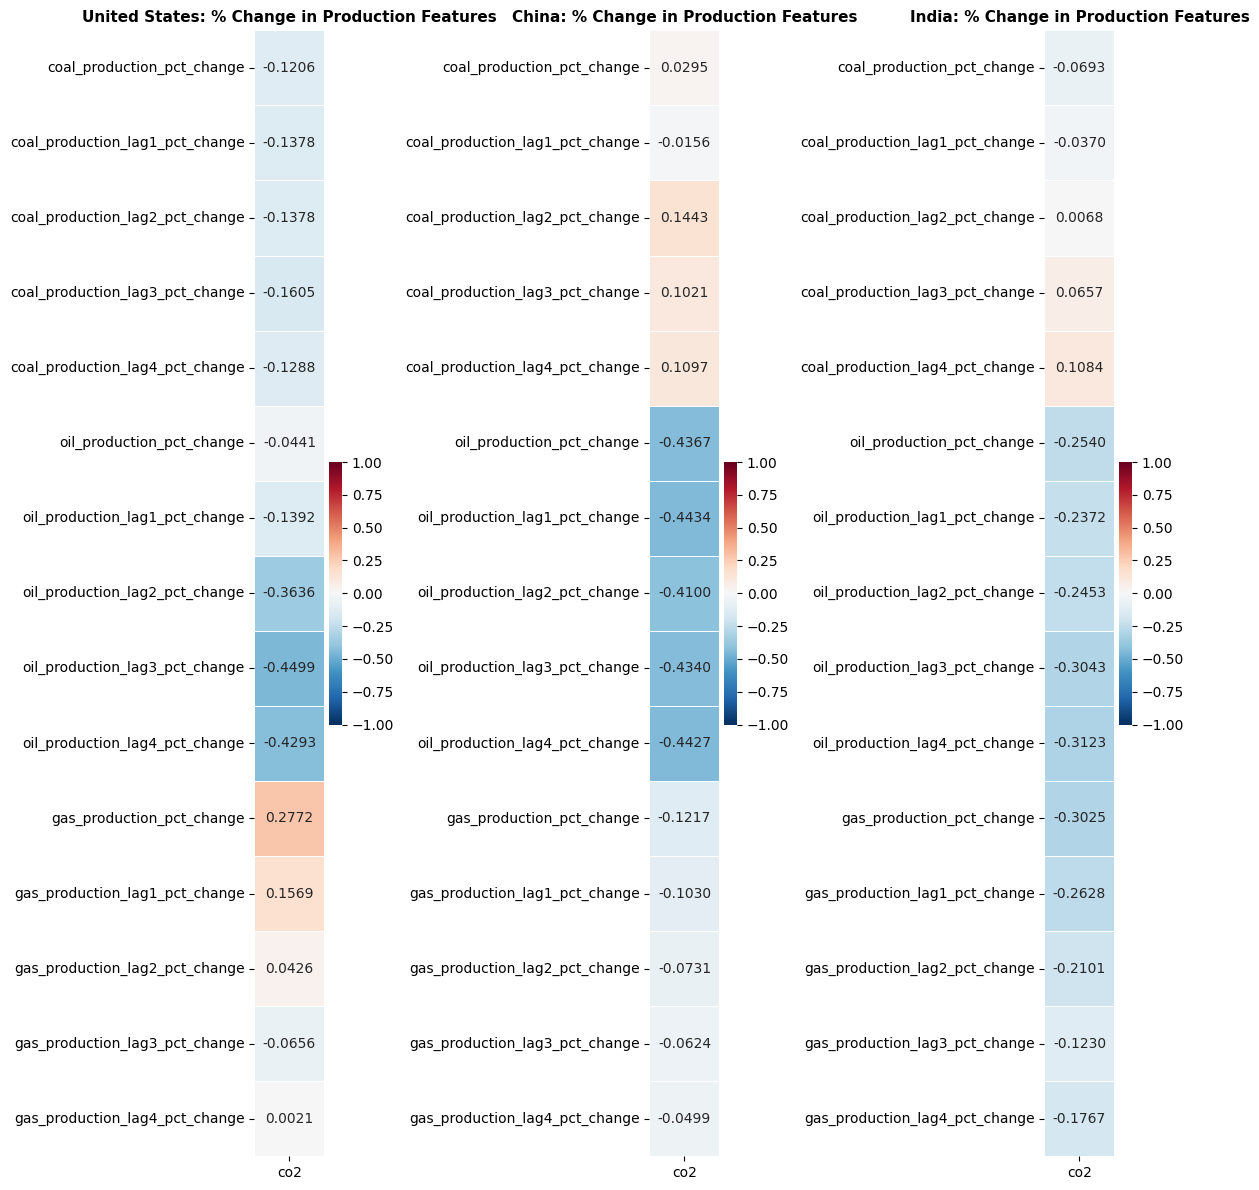

In [47]:
# Prod
fig1, axes1 = plt.subplots(1, 3, figsize=(12, 12))

for idx, country in enumerate(SELECTED_COUNTRIES):
    ax = axes1[idx]
    corr_matrix = prod_corr[country].to_frame()
    sns.heatmap(corr_matrix, annot=True, fmt='.4f', cmap='RdBu_r', center=0,
                vmin=-1, vmax=1, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax)
    ax.set_title(f'{country}: % Change in Production Features', fontsize=11, fontweight='bold')

#plt.suptitle('Correlations with CO2 by Country', fontsize=14, fontweight='bold')
plt.tight_layout()
plot_filepath1 = os.path.join(save_dir, 'production_heatmap.png')
plt.savefig(plot_filepath1, dpi=150, bbox_inches='tight')
plt.show()

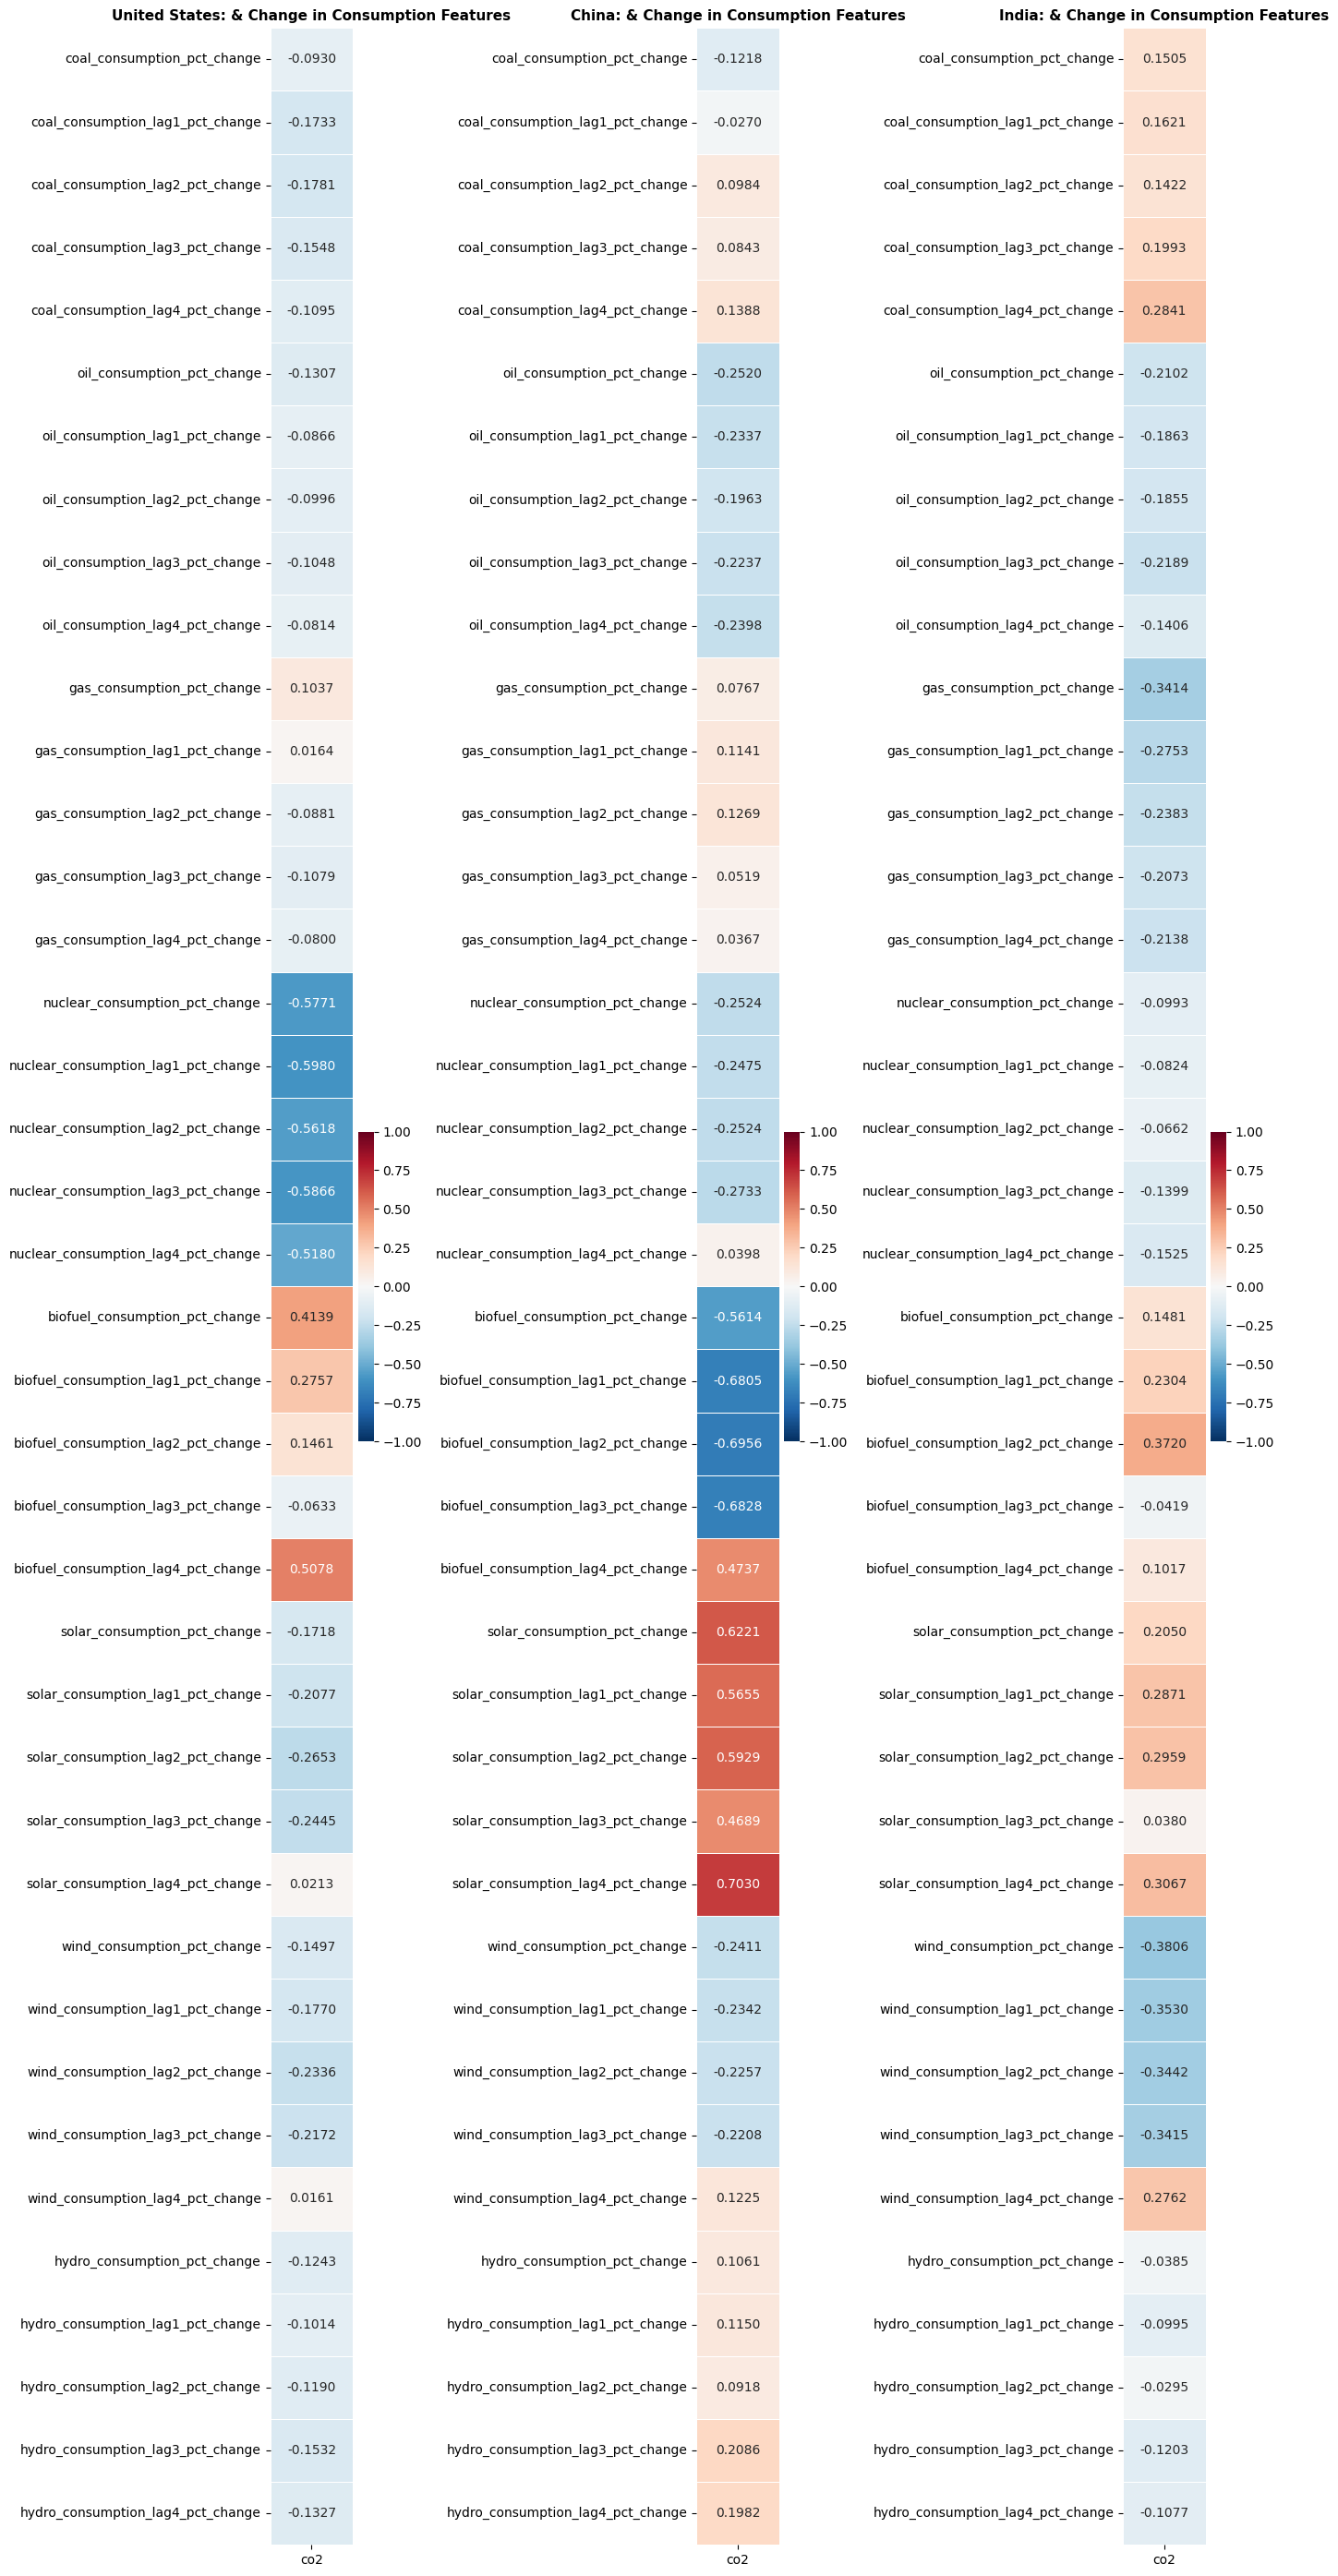

In [48]:
# Cons
fig2, axes2 = plt.subplots(1, 3, figsize=(14, 28))

for idx, country in enumerate(SELECTED_COUNTRIES):
    ax = axes2[idx]
    corr_matrix = cons_corr[country].to_frame()
    sns.heatmap(corr_matrix, annot=True, fmt='.4f', cmap='RdBu_r', center=0,
                vmin=-1, vmax=1, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax)
    ax.set_title(f'{country}: & Change in Consumption Features', fontsize=11, fontweight='bold')

#plt.suptitle('Correlations with CO2 by Country', fontsize=14, fontweight='bold')
plt.tight_layout()
plot_filepath2 = os.path.join(save_dir, 'consumption_heatmap.png')
plt.savefig(plot_filepath2, dpi=150, bbox_inches='tight')
plt.show()

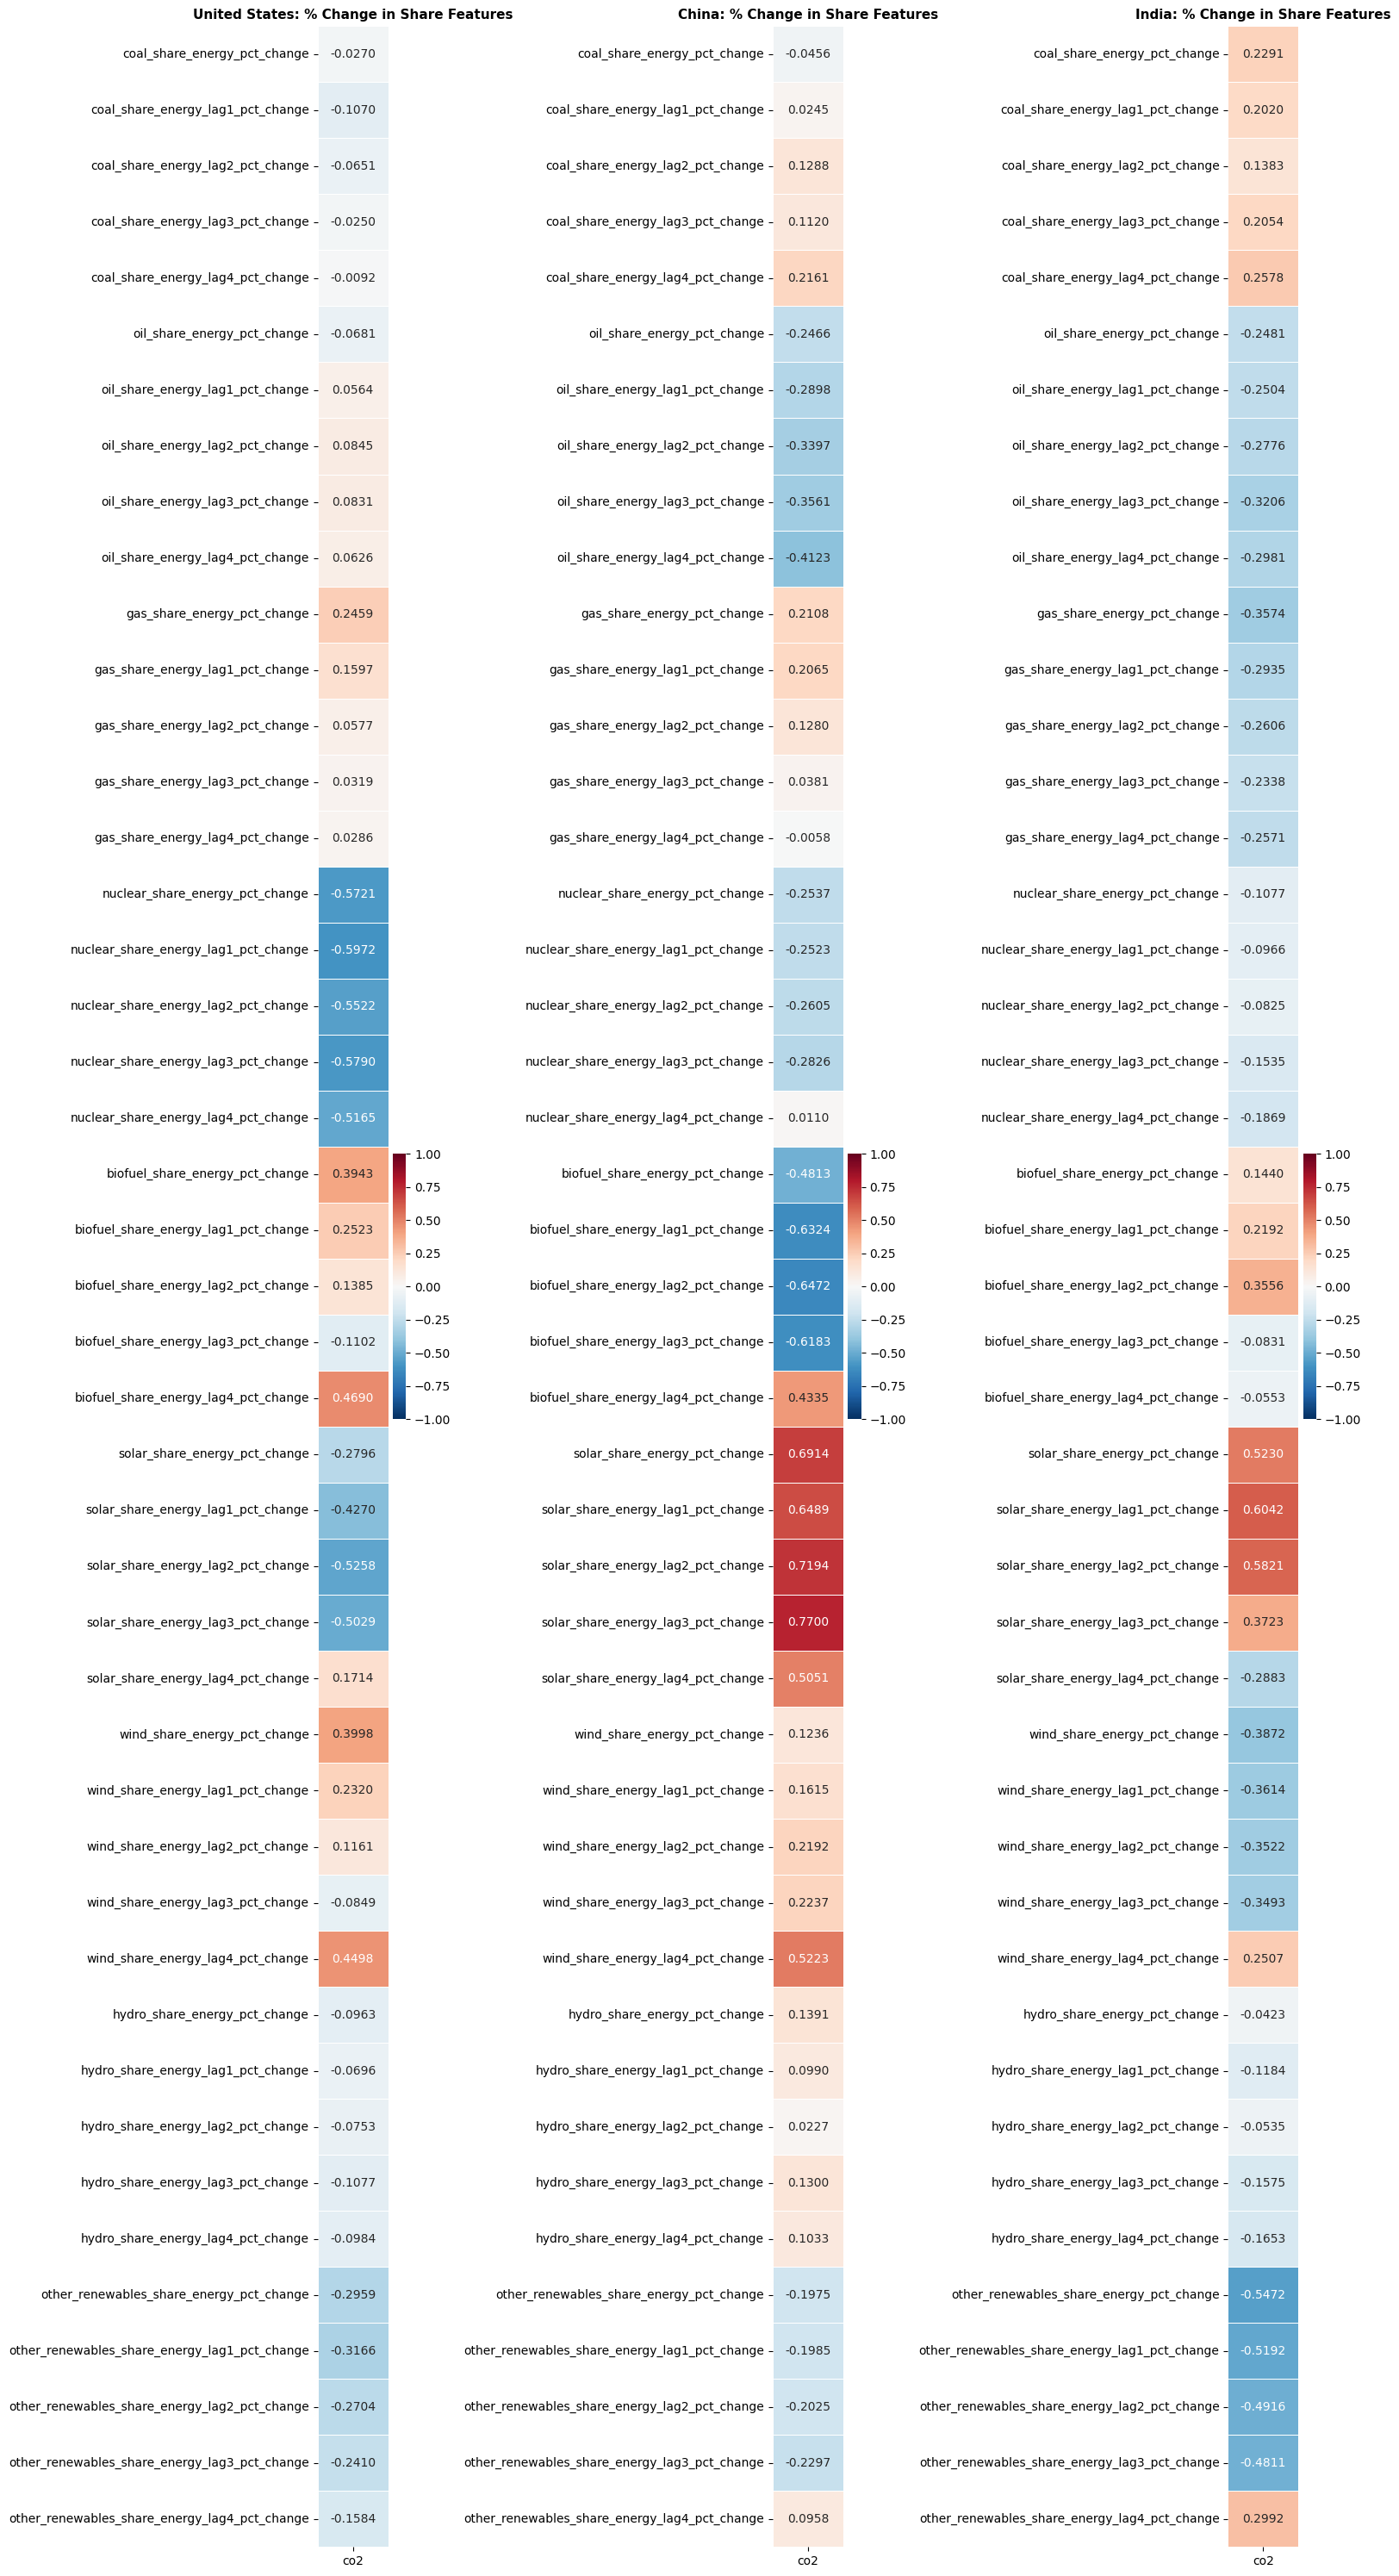

In [54]:
# Share
fig3, axes3 = plt.subplots(1, 3, figsize=(16, 30))

for idx, country in enumerate(SELECTED_COUNTRIES):
    ax = axes3[idx]
    corr_matrix = share_corr[country].to_frame()
    sns.heatmap(corr_matrix, annot=True, fmt='.4f', cmap='RdBu_r', center=0,
                vmin=-1, vmax=1, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax)
    ax.set_title(f'{country}: % Change in Share Features', fontsize=11, fontweight='bold')

#plt.suptitle('Correlations with CO2 by Country', fontsize=14, fontweight='bold')
plt.tight_layout()
plot_filepath3 = os.path.join(save_dir, 'share_heatmap.png')
plt.savefig(plot_filepath3, dpi=150, bbox_inches='tight')
plt.show()